## Conditional Image Synthesis with Auxiliary Classifier GANs

- A new methods for the improved training of generative adversarial networks (GANs) for image synthesis.
- AC-GAN enhances the traditional GAN structure by adding an auxiliary classifier to the discriminator, allowing it to not only distinguish between real and fake data but also to predict the class label of the data.

## Source

- paper: https://arxiv.org/abs/1610.09585
- code: https://github.com/buriburisuri/ac-gan

## Architecture

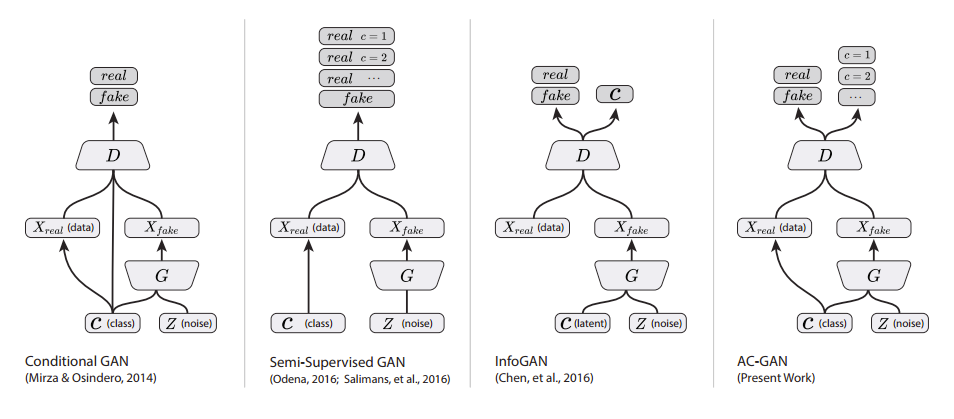

### Formulation

#### Discriminator Loss

- $
L_S = \mathbb{E}[\log P(S = \text{real} \mid X_{\text{real}})] + \mathbb{E}[\log P(S = \text{fake} \mid X_{\text{fake}})]
$


- $
L_C = \mathbb{E}[\log P(C = c \mid X_{\text{real}})] + \mathbb{E}[\log P(C = c \mid X_{\text{fake}})]
$

- $L_D = L_S + L_C$

- $L_S$ Adversarial loss for discriminator
- $L_C$ Classification loss for discriminator
- $L_D$ total loss for discriminator


#### Generator Loss

- $L_S = \mathbb{E}[\log P(S = \text{real} \mid X_{\text{fake}})]$
- $L_C = \mathbb{E}[\log P(C = c \mid X_{\text{fake}})]$
 
- $L_G = L_S + L_C$

- $L_S$ Adversarial loss for generator
- $L_C$ Classification loss for generator
- $L_G$ total loss for generator

## Implementation

### Import Necessary Libraries

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

In [56]:
latent_dim = 100
num_classes = 10
img_shape = (28, 28, 1)

### Define the Generator

In [59]:
# input1: 100 dimension noise
# input2: img lable 

# output: 28*28*1 img

def build_generator(latent_dim, num_classes, img_shape):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,), dtype='int32')
    
    label_embedding = layers.Flatten()(layers.Embedding(num_classes, latent_dim)(label))
    model_input = layers.multiply([noise, label_embedding])
    
    x = layers.Dense(128 * 7 * 7, activation="relu")(model_input)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.Activation("relu")(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(img_shape[2], kernel_size=3, padding="same")(x)
    img = layers.Activation("tanh")(x)
    
    return Model([noise, label], img)


In [57]:
g = build_generator(latent_dim, num_classes, img_shape)

In [58]:
g.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 100)               1000      ['input_17[0][0]']            
                                                                                                  
 input_16 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 flatten_6 (Flatten)         (None, 100)                  0         ['embedding_3[0][0]']         
                                                                                            

### Define the Discriminator

In [61]:
# input1 img 28*28*1
# output1 probability for real img
# output2 img label

def build_discriminator(img_shape, num_classes):
    img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(img)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.ZeroPadding2D(padding=((0,1),(0,1)))(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(512, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    
    validity = layers.Dense(1, activation="sigmoid")(x)
    label = layers.Dense(num_classes, activation="softmax")(x)
    
    return Model(img, [validity, label])


In [60]:
d = build_discriminator(img_shape, num_classes)
d.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 14, 14, 64)           640       ['input_18[0][0]']            
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)           0         ['conv2d_24[0][0]']           
                                                                                                  
 dropout_12 (Dropout)        (None, 14, 14, 64)           0         ['leaky_re_lu_12[0][0]']      
                                                                                           

### Compile the Models

In [41]:
latent_dim = 100
num_classes = 10
img_shape = (28, 28, 1)

# Build and compile the discriminator
discriminator = build_discriminator(img_shape, num_classes)
discriminator.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
                      optimizer=tf.keras.optimizers.Adam(0.0001, 0.5),
                      metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim, num_classes, img_shape)

# The generator takes noise and the target label as input and generates images
z = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,))
img = generator([z, label])

# For the combined model, we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity and class label
validity, target_label = discriminator(img)

# The combined model (stacked generator and discriminator)
combined = Model([z, label], [validity, target_label])
combined.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
                 optimizer=tf.keras.optimizers.Adam(0.0001, 0.5))


### Define the training function

In [42]:
def train(epochs, batch_size=128):
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    d_losses = []
    g_losses = []
    d_accuracies = []

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_imgs = generator.predict([noise, gen_labels])

        d_loss_real = discriminator.train_on_batch(imgs, [real, labels])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, gen_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size)

        g_loss = combined.train_on_batch([noise, sampled_labels], [real, sampled_labels])

        d_losses.append(d_loss[0])
        d_accuracies.append(100 * d_loss[3])
        g_losses.append(g_loss[0])

        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[3]:.2f}%, real acc.: {100 * d_loss_real[3]:.2f}%, fake acc.: {100 * d_loss_fake[3]:.2f}%] [G loss: {g_loss[0]}]")

    return d_losses, g_losses, d_accuracies

In [43]:
def plot_metrics(d_losses, g_losses, d_accuracies):
    epochs = range(len(d_losses))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, d_losses, label="Discriminator Loss")
    plt.plot(epochs, g_losses, label="Generator Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Losses")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, d_accuracies, label="Discriminator Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title("Discriminator Accuracy")

    plt.tight_layout()
    plt.show()



### Training

In [48]:
# Start training
d_losses, g_losses, d_accuracies = train(epochs=4000, batch_size=64)


2/2 [==============================] - 0s 20ms/step
0 [D loss: 0.1712394878268242, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1843233108520508]
2/2 [==============================] - 0s 23ms/step
1 [D loss: 0.17093698680400848, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0463392734527588]
2/2 [==============================] - 0s 22ms/step
2 [D loss: 0.2545635998249054, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1886060237884521]
2/2 [==============================] - 0s 21ms/step
3 [D loss: 0.21367915347218513, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2922533750534058]
2/2 [==============================] - 0s 21ms/step
4 [D loss: 0.34888169169425964, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8760234713554382]
2/2 [==============================] - 0s 22ms/step
5 [D loss: 0.28375574946403503, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.918361186981

2/2 [==============================] - 0s 20ms/step
49 [D loss: 0.22146108001470566, acc.: 98.44%, real acc.: 96.88%, fake acc.: 100.00%] [G loss: 1.6266226768493652]
2/2 [==============================] - 0s 19ms/step
50 [D loss: 0.4082713723182678, acc.: 97.66%, real acc.: 98.44%, fake acc.: 96.88%] [G loss: 1.632108211517334]
2/2 [==============================] - 0s 19ms/step
51 [D loss: 0.2541283816099167, acc.: 99.22%, real acc.: 98.44%, fake acc.: 100.00%] [G loss: 1.7127281427383423]
2/2 [==============================] - 0s 18ms/step
52 [D loss: 0.2984076216816902, acc.: 91.41%, real acc.: 82.81%, fake acc.: 100.00%] [G loss: 1.614591360092163]
2/2 [==============================] - 0s 22ms/step
53 [D loss: 0.5059006884694099, acc.: 82.81%, real acc.: 100.00%, fake acc.: 65.62%] [G loss: 1.4296813011169434]
2/2 [==============================] - 0s 21ms/step
54 [D loss: 0.4464021846652031, acc.: 93.75%, real acc.: 87.50%, fake acc.: 100.00%] [G loss: 1.4859566688537598]
2/2 [=

2/2 [==============================] - 0s 18ms/step
147 [D loss: 0.2771284133195877, acc.: 99.22%, real acc.: 98.44%, fake acc.: 100.00%] [G loss: 1.1098177433013916]
2/2 [==============================] - 0s 17ms/step
148 [D loss: 0.2550257444381714, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9254917502403259]
2/2 [==============================] - 0s 19ms/step
149 [D loss: 0.3200981244444847, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9578940272331238]
2/2 [==============================] - 0s 19ms/step
150 [D loss: 0.33491234481334686, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1692472696304321]
2/2 [==============================] - 0s 21ms/step
151 [D loss: 0.17087183892726898, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1604238748550415]
2/2 [==============================] - 0s 18ms/step
152 [D loss: 0.36964452266693115, acc.: 97.66%, real acc.: 100.00%, fake acc.: 95.31%] [G loss: 1.22203

2/2 [==============================] - 0s 20ms/step
196 [D loss: 0.3284236937761307, acc.: 97.66%, real acc.: 100.00%, fake acc.: 95.31%] [G loss: 1.1966884136199951]
2/2 [==============================] - 0s 22ms/step
197 [D loss: 0.2764328718185425, acc.: 96.09%, real acc.: 100.00%, fake acc.: 92.19%] [G loss: 0.8183748722076416]
2/2 [==============================] - 0s 22ms/step
198 [D loss: 0.296565406024456, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.4881600141525269]
2/2 [==============================] - 0s 21ms/step
199 [D loss: 0.1742696799337864, acc.: 99.22%, real acc.: 98.44%, fake acc.: 100.00%] [G loss: 1.4455699920654297]
2/2 [==============================] - 0s 20ms/step
200 [D loss: 0.19507822953164577, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.553239345550537]
2/2 [==============================] - 0s 19ms/step
201 [D loss: 0.11754269897937775, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.3239710330

2/2 [==============================] - 0s 20ms/step
245 [D loss: 0.0870039165019989, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8320567607879639]
2/2 [==============================] - 0s 19ms/step
246 [D loss: 0.32941387593746185, acc.: 98.44%, real acc.: 98.44%, fake acc.: 98.44%] [G loss: 0.8625794053077698]
2/2 [==============================] - 0s 20ms/step
247 [D loss: 0.42271000146865845, acc.: 90.62%, real acc.: 100.00%, fake acc.: 81.25%] [G loss: 1.0288100242614746]
2/2 [==============================] - 0s 19ms/step
248 [D loss: 0.3807811811566353, acc.: 98.44%, real acc.: 96.88%, fake acc.: 100.00%] [G loss: 1.4970319271087646]
2/2 [==============================] - 0s 19ms/step
249 [D loss: 0.31263910233974457, acc.: 89.06%, real acc.: 78.12%, fake acc.: 100.00%] [G loss: 1.5793122053146362]
2/2 [==============================] - 0s 20ms/step
250 [D loss: 0.20489128679037094, acc.: 99.22%, real acc.: 100.00%, fake acc.: 98.44%] [G loss: 1.04829633235

2/2 [==============================] - 0s 19ms/step
294 [D loss: 0.2340344414114952, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0309454202651978]
2/2 [==============================] - 0s 20ms/step
295 [D loss: 0.16478385962545872, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.3375074863433838]
2/2 [==============================] - 0s 24ms/step
296 [D loss: 0.07442299276590347, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.6811362504959106]
2/2 [==============================] - 0s 20ms/step
297 [D loss: 0.2117641717195511, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2713629007339478]
2/2 [==============================] - 0s 21ms/step
298 [D loss: 0.22246604785323143, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.3438725471496582]
2/2 [==============================] - 0s 19ms/step
299 [D loss: 0.24263078346848488, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.

2/2 [==============================] - 0s 21ms/step
343 [D loss: 0.23201121389865875, acc.: 99.22%, real acc.: 100.00%, fake acc.: 98.44%] [G loss: 0.7137105464935303]
2/2 [==============================] - 0s 19ms/step
344 [D loss: 0.2536829113960266, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9949730038642883]
2/2 [==============================] - 0s 19ms/step
345 [D loss: 0.15817385539412498, acc.: 99.22%, real acc.: 98.44%, fake acc.: 100.00%] [G loss: 1.2101019620895386]
2/2 [==============================] - 0s 21ms/step
346 [D loss: 0.20461511611938477, acc.: 99.22%, real acc.: 98.44%, fake acc.: 100.00%] [G loss: 1.1569032669067383]
2/2 [==============================] - 0s 22ms/step
347 [D loss: 0.2632167935371399, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0898478031158447]
2/2 [==============================] - 0s 21ms/step
348 [D loss: 0.15896272286772728, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.862899

2/2 [==============================] - 0s 20ms/step
392 [D loss: 0.1209273636341095, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1601948738098145]
2/2 [==============================] - 0s 20ms/step
393 [D loss: 0.15688693895936012, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1847981214523315]
2/2 [==============================] - 0s 16ms/step
394 [D loss: 0.2498161941766739, acc.: 96.88%, real acc.: 100.00%, fake acc.: 93.75%] [G loss: 0.9178833961486816]
2/2 [==============================] - 0s 22ms/step
395 [D loss: 0.11505575105547905, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1610548496246338]
2/2 [==============================] - 0s 20ms/step
396 [D loss: 0.1264687478542328, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2867655754089355]
2/2 [==============================] - 0s 19ms/step
397 [D loss: 0.4542693942785263, acc.: 89.84%, real acc.: 82.81%, fake acc.: 96.88%] [G loss: 1.1299279

2/2 [==============================] - 0s 23ms/step
441 [D loss: 0.19428402185440063, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0094143152236938]
2/2 [==============================] - 0s 19ms/step
442 [D loss: 0.1778976023197174, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9917980432510376]
2/2 [==============================] - 0s 18ms/step
443 [D loss: 0.10497893020510674, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9560340642929077]
2/2 [==============================] - 0s 20ms/step
444 [D loss: 0.19654099643230438, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7926521897315979]
2/2 [==============================] - 0s 20ms/step
445 [D loss: 0.14274169877171516, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9429839849472046]
2/2 [==============================] - 0s 20ms/step
446 [D loss: 0.15646475926041603, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0

2/2 [==============================] - 0s 21ms/step
490 [D loss: 0.32627178728580475, acc.: 90.62%, real acc.: 100.00%, fake acc.: 81.25%] [G loss: 0.9115738272666931]
2/2 [==============================] - 0s 18ms/step
491 [D loss: 0.32653309404850006, acc.: 93.75%, real acc.: 87.50%, fake acc.: 100.00%] [G loss: 1.1309813261032104]
2/2 [==============================] - 0s 19ms/step
492 [D loss: 0.18213585019111633, acc.: 98.44%, real acc.: 96.88%, fake acc.: 100.00%] [G loss: 1.3027230501174927]
2/2 [==============================] - 0s 18ms/step
493 [D loss: 0.23315399885177612, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1606272459030151]
2/2 [==============================] - 0s 19ms/step
494 [D loss: 0.26720986515283585, acc.: 97.66%, real acc.: 100.00%, fake acc.: 95.31%] [G loss: 0.7188518643379211]
2/2 [==============================] - 0s 19ms/step
495 [D loss: 0.14920161664485931, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.749897

2/2 [==============================] - 0s 23ms/step
539 [D loss: 0.08732984587550163, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.116830587387085]
2/2 [==============================] - 0s 19ms/step
540 [D loss: 0.1320687048137188, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.169232964515686]
2/2 [==============================] - 0s 18ms/step
541 [D loss: 0.17436087131500244, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.252956748008728]
2/2 [==============================] - 0s 18ms/step
542 [D loss: 0.17449841275811195, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.129504680633545]
2/2 [==============================] - 0s 18ms/step
543 [D loss: 0.18134722113609314, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.061794638633728]
2/2 [==============================] - 0s 20ms/step
544 [D loss: 0.3058212175965309, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.15980

2/2 [==============================] - 0s 19ms/step
588 [D loss: 0.20094727724790573, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.5593067407608032]
2/2 [==============================] - 0s 20ms/step
589 [D loss: 0.10782882198691368, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.5684192180633545]
2/2 [==============================] - 0s 18ms/step
590 [D loss: 0.11125630885362625, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.777488112449646]
2/2 [==============================] - 0s 20ms/step
591 [D loss: 0.1417926773428917, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.571312665939331]
2/2 [==============================] - 0s 21ms/step
592 [D loss: 0.11532830074429512, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.692351222038269]
2/2 [==============================] - 0s 22ms/step
593 [D loss: 0.15066365897655487, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.65

2/2 [==============================] - 0s 21ms/step
637 [D loss: 0.21525895223021507, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8510732054710388]
2/2 [==============================] - 0s 21ms/step
638 [D loss: 0.13974837958812714, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6846978664398193]
2/2 [==============================] - 0s 21ms/step
639 [D loss: 0.07679613120853901, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8628286719322205]
2/2 [==============================] - 0s 20ms/step
640 [D loss: 0.16214819252490997, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7112908363342285]
2/2 [==============================] - 0s 18ms/step
641 [D loss: 0.15215853974223137, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9133274555206299]
2/2 [==============================] - 0s 20ms/step
642 [D loss: 0.12668437138199806, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 

2/2 [==============================] - 0s 21ms/step
686 [D loss: 0.08401207067072392, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8687059879302979]
2/2 [==============================] - 0s 19ms/step
687 [D loss: 0.15594711527228355, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8085183501243591]
2/2 [==============================] - 0s 20ms/step
688 [D loss: 0.07714526541531086, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.627560019493103]
2/2 [==============================] - 0s 21ms/step
689 [D loss: 0.11791910976171494, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5748450756072998]
2/2 [==============================] - 0s 20ms/step
690 [D loss: 0.08439613878726959, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6954257488250732]
2/2 [==============================] - 0s 21ms/step
691 [D loss: 0.19443073496222496, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0

2/2 [==============================] - 0s 20ms/step
783 [D loss: 0.08083390817046165, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5933009386062622]
2/2 [==============================] - 0s 19ms/step
784 [D loss: 0.11424552649259567, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6037785410881042]
2/2 [==============================] - 0s 21ms/step
785 [D loss: 0.19044461846351624, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5560582876205444]
2/2 [==============================] - 0s 20ms/step
786 [D loss: 0.12819994799792767, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5013013482093811]
2/2 [==============================] - 0s 23ms/step
787 [D loss: 0.17868343368172646, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.43223652243614197]
2/2 [==============================] - 0s 20ms/step
788 [D loss: 0.13741233572363853, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss:

2/2 [==============================] - 0s 19ms/step
832 [D loss: 0.12689178623259068, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8982337713241577]
2/2 [==============================] - 0s 20ms/step
833 [D loss: 0.09277277812361717, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8651540875434875]
2/2 [==============================] - 0s 19ms/step
834 [D loss: 0.11011100932955742, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1060690879821777]
2/2 [==============================] - 0s 20ms/step
835 [D loss: 0.12022850289940834, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9041863679885864]
2/2 [==============================] - 0s 19ms/step
836 [D loss: 0.14341406896710396, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.019041657447815]
2/2 [==============================] - 0s 21ms/step
837 [D loss: 0.06799247488379478, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1

928 [D loss: 0.13561838306486607, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.5010288953781128]
2/2 [==============================] - 0s 23ms/step
929 [D loss: 0.09851944074034691, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.282547950744629]
2/2 [==============================] - 0s 20ms/step
930 [D loss: 0.10972899571061134, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.5779975652694702]
2/2 [==============================] - 0s 19ms/step
931 [D loss: 0.16930727288126945, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2558813095092773]
2/2 [==============================] - 0s 22ms/step
932 [D loss: 0.15442265570163727, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.4650444984436035]
2/2 [==============================] - 0s 18ms/step
933 [D loss: 0.059145824052393436, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.079893946647644]
2/2 [============================

2/2 [==============================] - 0s 18ms/step
977 [D loss: 0.12070129625499249, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.386321783065796]
2/2 [==============================] - 0s 18ms/step
978 [D loss: 0.054232324473559856, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.4070698022842407]
2/2 [==============================] - 0s 18ms/step
979 [D loss: 0.12331996113061905, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1649930477142334]
2/2 [==============================] - 0s 17ms/step
980 [D loss: 0.054304566234350204, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2942665815353394]
2/2 [==============================] - 0s 19ms/step
981 [D loss: 0.10669685900211334, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.706566572189331]
2/2 [==============================] - 0s 25ms/step
982 [D loss: 0.07927663810551167, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 

2/2 [==============================] - 0s 19ms/step
1073 [D loss: 0.14104400016367435, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.8234511613845825]
2/2 [==============================] - 0s 19ms/step
1074 [D loss: 0.1763949990272522, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.7898151874542236]
2/2 [==============================] - 0s 22ms/step
1075 [D loss: 0.12482275813817978, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.3894908428192139]
2/2 [==============================] - 0s 21ms/step
1076 [D loss: 0.1851749587804079, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.420383334159851]
2/2 [==============================] - 0s 19ms/step
1077 [D loss: 0.2504334934055805, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.5058228969573975]
2/2 [==============================] - 0s 18ms/step
1078 [D loss: 0.14519611932337284, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss

2/2 [==============================] - 0s 18ms/step
1121 [D loss: 0.10570692550390959, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9961442351341248]
2/2 [==============================] - 0s 19ms/step
1122 [D loss: 0.10418410878628492, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1366554498672485]
2/2 [==============================] - 0s 24ms/step
1123 [D loss: 0.11108150705695152, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.4541335105895996]
2/2 [==============================] - 0s 21ms/step
1124 [D loss: 0.1328336950391531, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.138270378112793]
2/2 [==============================] - 0s 19ms/step
1125 [D loss: 0.14988363534212112, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0465543270111084]
2/2 [==============================] - 0s 19ms/step
1126 [D loss: 0.060584861785173416, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 22ms/step
1169 [D loss: 0.18115993589162827, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6133780479431152]
2/2 [==============================] - 0s 22ms/step
1170 [D loss: 0.08557576965540648, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5652177333831787]
2/2 [==============================] - 0s 20ms/step
1171 [D loss: 0.1362999463453889, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6252439022064209]
2/2 [==============================] - 0s 21ms/step
1172 [D loss: 0.050261057913303375, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5493481755256653]
2/2 [==============================] - 0s 21ms/step
1173 [D loss: 0.17629969865083694, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6101905703544617]
2/2 [==============================] - 0s 19ms/step
1174 [D loss: 0.1282132277265191, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 20ms/step
1265 [D loss: 0.08477592095732689, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6559068560600281]
2/2 [==============================] - 0s 20ms/step
1266 [D loss: 0.05684460140764713, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1205781698226929]
2/2 [==============================] - 0s 23ms/step
1267 [D loss: 0.09800815768539906, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0767300128936768]
2/2 [==============================] - 0s 22ms/step
1268 [D loss: 0.07743124384433031, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.4298840761184692]
2/2 [==============================] - 0s 24ms/step
1269 [D loss: 0.12419512122869492, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2603771686553955]
2/2 [==============================] - 0s 21ms/step
1270 [D loss: 0.15303169935941696, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G 

2/2 [==============================] - 0s 20ms/step
1313 [D loss: 0.15351205691695213, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.7838339805603027]
2/2 [==============================] - 0s 20ms/step
1314 [D loss: 0.06870779395103455, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.9077950716018677]
2/2 [==============================] - 0s 21ms/step
1315 [D loss: 0.0693549606949091, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.491081476211548]
2/2 [==============================] - 0s 19ms/step
1316 [D loss: 0.13335436955094337, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 3.2518277168273926]
2/2 [==============================] - 0s 21ms/step
1317 [D loss: 0.074886754155159, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 3.6181249618530273]
2/2 [==============================] - 0s 21ms/step
1318 [D loss: 0.11638188362121582, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss

2/2 [==============================] - 0s 22ms/step
1409 [D loss: 0.05180419981479645, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.45185497403144836]
2/2 [==============================] - 0s 21ms/step
1410 [D loss: 0.11789112910628319, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7656691670417786]
2/2 [==============================] - 0s 21ms/step
1411 [D loss: 0.07210765592753887, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8590070009231567]
2/2 [==============================] - 0s 23ms/step
1412 [D loss: 0.05505923181772232, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.849734365940094]
2/2 [==============================] - 0s 21ms/step
1413 [D loss: 0.04299336299300194, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6753847002983093]
2/2 [==============================] - 0s 18ms/step
1414 [D loss: 0.0738370344042778, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 34ms/step
1457 [D loss: 0.10549635253846645, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.8386809825897217]
2/2 [==============================] - 0s 21ms/step
1458 [D loss: 0.07359246164560318, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.9130942821502686]
2/2 [==============================] - 0s 21ms/step
1459 [D loss: 0.12851937487721443, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.8216642141342163]
2/2 [==============================] - 0s 22ms/step
1460 [D loss: 0.03567670565098524, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.8790712356567383]
2/2 [==============================] - 0s 23ms/step
1461 [D loss: 0.12260684370994568, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.25705885887146]
2/2 [==============================] - 0s 22ms/step
1462 [D loss: 0.14684933051466942, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G lo

2/2 [==============================] - 0s 20ms/step
1505 [D loss: 0.118234533816576, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5812569260597229]
2/2 [==============================] - 0s 22ms/step
1506 [D loss: 0.04516207426786423, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6226025819778442]
2/2 [==============================] - 0s 23ms/step
1507 [D loss: 0.10510820941999555, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6471042037010193]
2/2 [==============================] - 0s 22ms/step
1508 [D loss: 0.10368905402719975, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8789613842964172]
2/2 [==============================] - 0s 21ms/step
1509 [D loss: 0.05138997733592987, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8963341116905212]
2/2 [==============================] - 0s 21ms/step
1510 [D loss: 0.09545149374753237, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G lo

2/2 [==============================] - 0s 18ms/step
1601 [D loss: 0.1268338728696108, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0899155139923096]
2/2 [==============================] - 0s 17ms/step
1602 [D loss: 0.0806913822889328, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2366026639938354]
2/2 [==============================] - 0s 19ms/step
1603 [D loss: 0.11519320122897625, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0183383226394653]
2/2 [==============================] - 0s 18ms/step
1604 [D loss: 0.08528400817885995, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2235004901885986]
2/2 [==============================] - 0s 19ms/step
1605 [D loss: 0.0806792895309627, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.5160033702850342]
2/2 [==============================] - 0s 18ms/step
1606 [D loss: 0.09195231134071946, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G los

2/2 [==============================] - 0s 19ms/step
1697 [D loss: 0.13134518638253212, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9081780910491943]
2/2 [==============================] - 0s 21ms/step
1698 [D loss: 0.0683323796838522, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9028664231300354]
2/2 [==============================] - 0s 21ms/step
1699 [D loss: 0.11354439705610275, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0719044208526611]
2/2 [==============================] - 0s 22ms/step
1700 [D loss: 0.05184012604877353, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8992024660110474]
2/2 [==============================] - 0s 21ms/step
1701 [D loss: 0.03102802950888872, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8528890609741211]
2/2 [==============================] - 0s 20ms/step
1702 [D loss: 0.06158962193876505, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 21ms/step
1745 [D loss: 0.044776517897844315, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0891038179397583]
2/2 [==============================] - 0s 21ms/step
1746 [D loss: 0.2019692175090313, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1347906589508057]
2/2 [==============================] - 0s 19ms/step
1747 [D loss: 0.07313024159520864, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0527639389038086]
2/2 [==============================] - 0s 20ms/step
1748 [D loss: 0.04948419565334916, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.043912410736084]
2/2 [==============================] - 0s 19ms/step
1749 [D loss: 0.13211233960464597, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.000300407409668]
2/2 [==============================] - 0s 20ms/step
1750 [D loss: 0.05625944584608078, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G lo

2/2 [==============================] - 0s 23ms/step
1793 [D loss: 0.06415539514273405, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9674761891365051]
2/2 [==============================] - 0s 19ms/step
1794 [D loss: 0.08987569063901901, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6498931646347046]
2/2 [==============================] - 0s 21ms/step
1795 [D loss: 0.03647010959684849, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8736464977264404]
2/2 [==============================] - 0s 23ms/step
1796 [D loss: 0.1532094143331051, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6910008788108826]
2/2 [==============================] - 0s 22ms/step
1797 [D loss: 0.07106871530413628, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6710630655288696]
2/2 [==============================] - 0s 22ms/step
1798 [D loss: 0.05373596819117665, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 21ms/step
1841 [D loss: 0.11315414402633905, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7496755719184875]
2/2 [==============================] - 0s 21ms/step
1842 [D loss: 0.09657724760472775, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5090845227241516]
2/2 [==============================] - 0s 19ms/step
1843 [D loss: 0.021236042957752943, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4892158806324005]
2/2 [==============================] - 0s 20ms/step
1844 [D loss: 0.06861926801502705, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6254984736442566]
2/2 [==============================] - 0s 18ms/step
1845 [D loss: 0.028308983892202377, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6135197281837463]
2/2 [==============================] - 0s 20ms/step
1846 [D loss: 0.043700543232262135, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] 

2/2 [==============================] - 0s 21ms/step
1889 [D loss: 0.08098842576146126, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9308741688728333]
2/2 [==============================] - 0s 19ms/step
1890 [D loss: 0.1091034784913063, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9319206476211548]
2/2 [==============================] - 0s 22ms/step
1891 [D loss: 0.1318381130695343, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6193437576293945]
2/2 [==============================] - 0s 19ms/step
1892 [D loss: 0.06300973147153854, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6999691724777222]
2/2 [==============================] - 0s 22ms/step
1893 [D loss: 0.05348892416805029, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6141027212142944]
2/2 [==============================] - 0s 19ms/step
1894 [D loss: 0.07632149290293455, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G lo

2/2 [==============================] - 0s 18ms/step
1985 [D loss: 0.1297980733215809, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.48036399483680725]
2/2 [==============================] - 0s 17ms/step
1986 [D loss: 0.09745540469884872, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4062783420085907]
2/2 [==============================] - 0s 21ms/step
1987 [D loss: 0.06969469785690308, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5391590595245361]
2/2 [==============================] - 0s 19ms/step
1988 [D loss: 0.06287932395935059, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4148712456226349]
2/2 [==============================] - 0s 18ms/step
1989 [D loss: 0.0688834898173809, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.35483261942863464]
2/2 [==============================] - 0s 21ms/step
1990 [D loss: 0.09655033983290195, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G 

2/2 [==============================] - 0s 23ms/step
2033 [D loss: 0.07037115655839443, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.21139945089817047]
2/2 [==============================] - 0s 24ms/step
2034 [D loss: 0.05069820582866669, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.2023075819015503]
2/2 [==============================] - 0s 21ms/step
2035 [D loss: 0.07210897654294968, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.2548083961009979]
2/2 [==============================] - 0s 20ms/step
2036 [D loss: 0.11171184666454792, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.21294784545898438]
2/2 [==============================] - 0s 24ms/step
2037 [D loss: 0.05732263810932636, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.17452472448349]
2/2 [==============================] - 0s 21ms/step
2038 [D loss: 0.1232687272131443, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 16ms/step
2081 [D loss: 0.12735553889069706, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.16991989314556122]
2/2 [==============================] - 0s 19ms/step
2082 [D loss: 0.05119481775909662, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.19689542055130005]
2/2 [==============================] - 0s 19ms/step
2083 [D loss: 0.21376123186200857, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.17220689356327057]
2/2 [==============================] - 0s 21ms/step
2084 [D loss: 0.044703688472509384, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.14629805088043213]
2/2 [==============================] - 0s 20ms/step
2085 [D loss: 0.07875262154266238, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.12174573540687561]
2/2 [==============================] - 0s 22ms/step
2086 [D loss: 0.09238085616379976, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00

2/2 [==============================] - 0s 22ms/step
2129 [D loss: 0.042138127610087395, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.23544830083847046]
2/2 [==============================] - 0s 20ms/step
2130 [D loss: 0.03929682169109583, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3874025046825409]
2/2 [==============================] - 0s 22ms/step
2131 [D loss: 0.027890543453395367, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.34473270177841187]
2/2 [==============================] - 0s 21ms/step
2132 [D loss: 0.08501695282757282, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.39354243874549866]
2/2 [==============================] - 0s 20ms/step
2133 [D loss: 0.054851544089615345, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4603290557861328]
2/2 [==============================] - 0s 27ms/step
2134 [D loss: 0.037025739438831806, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.0

2/2 [==============================] - 0s 22ms/step
2177 [D loss: 0.06793773733079433, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4438631236553192]
2/2 [==============================] - 0s 21ms/step
2178 [D loss: 0.08339998824521899, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.507187008857727]
2/2 [==============================] - 0s 20ms/step
2179 [D loss: 0.07708906382322311, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5275593996047974]
2/2 [==============================] - 0s 21ms/step
2180 [D loss: 0.06341092567890882, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.48273956775665283]
2/2 [==============================] - 0s 23ms/step
2181 [D loss: 0.06968707265332341, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5923613905906677]
2/2 [==============================] - 0s 21ms/step
2182 [D loss: 0.05868646502494812, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G 

2/2 [==============================] - 0s 27ms/step
2225 [D loss: 0.0794078391045332, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2626923322677612]
2/2 [==============================] - 0s 22ms/step
2226 [D loss: 0.053474824875593185, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.322178840637207]
2/2 [==============================] - 0s 21ms/step
2227 [D loss: 0.05486607924103737, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.4996074438095093]
2/2 [==============================] - 0s 20ms/step
2228 [D loss: 0.049786631017923355, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.018479347229004]
2/2 [==============================] - 0s 17ms/step
2229 [D loss: 0.01835855608806014, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7597885131835938]
2/2 [==============================] - 0s 21ms/step
2230 [D loss: 0.03561594896018505, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 19ms/step
2273 [D loss: 0.03932194458320737, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.48265308141708374]
2/2 [==============================] - 0s 19ms/step
2274 [D loss: 0.04303213767707348, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.49454909563064575]
2/2 [==============================] - 0s 20ms/step
2275 [D loss: 0.03272630553692579, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3751799762248993]
2/2 [==============================] - 0s 21ms/step
2276 [D loss: 0.18234843760728836, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3244638741016388]
2/2 [==============================] - 0s 20ms/step
2277 [D loss: 0.10534000024199486, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.32579708099365234]
2/2 [==============================] - 0s 19ms/step
2278 [D loss: 0.029895965475589037, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%]

2/2 [==============================] - 0s 23ms/step
2321 [D loss: 0.08261626865714788, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9607853889465332]
2/2 [==============================] - 0s 22ms/step
2322 [D loss: 0.03264760319143534, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7440860867500305]
2/2 [==============================] - 0s 20ms/step
2323 [D loss: 0.05691148713231087, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5958993434906006]
2/2 [==============================] - 0s 22ms/step
2324 [D loss: 0.07157383929006755, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8881124258041382]
2/2 [==============================] - 0s 18ms/step
2325 [D loss: 0.05193851003423333, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5201209783554077]
2/2 [==============================] - 0s 18ms/step
2326 [D loss: 0.042927354108542204, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G

2/2 [==============================] - 0s 19ms/step
2369 [D loss: 0.08265981869772077, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0135372877120972]
2/2 [==============================] - 0s 21ms/step
2370 [D loss: 0.03381786704994738, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8868329524993896]
2/2 [==============================] - 0s 20ms/step
2371 [D loss: 0.03883927036076784, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9846594929695129]
2/2 [==============================] - 0s 19ms/step
2372 [D loss: 0.05099153029732406, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2089192867279053]
2/2 [==============================] - 0s 21ms/step
2373 [D loss: 0.04066852852702141, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.514017105102539]
2/2 [==============================] - 0s 21ms/step
2374 [D loss: 0.12275121547281742, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 22ms/step
2417 [D loss: 0.06627881666645408, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9900522828102112]
2/2 [==============================] - 0s 21ms/step
2418 [D loss: 0.056506216526031494, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2075163125991821]
2/2 [==============================] - 0s 21ms/step
2419 [D loss: 0.04700434533879161, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9363692998886108]
2/2 [==============================] - 0s 20ms/step
2420 [D loss: 0.05453946231864393, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9190561175346375]
2/2 [==============================] - 0s 19ms/step
2421 [D loss: 0.1101263202726841, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7729015946388245]
2/2 [==============================] - 0s 19ms/step
2422 [D loss: 0.10440761223435402, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G 

2/2 [==============================] - 0s 21ms/step
2465 [D loss: 0.05059684347361326, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.37580636143684387]
2/2 [==============================] - 0s 19ms/step
2466 [D loss: 0.054342617746442556, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.41297224164009094]
2/2 [==============================] - 0s 17ms/step
2467 [D loss: 0.08986283314879984, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3709799647331238]
2/2 [==============================] - 0s 23ms/step
2468 [D loss: 0.06260898383334279, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3725684881210327]
2/2 [==============================] - 0s 20ms/step
2469 [D loss: 0.06435119267553091, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.49512606859207153]
2/2 [==============================] - 0s 20ms/step
2470 [D loss: 0.020134953316301107, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%

2/2 [==============================] - 0s 22ms/step
2513 [D loss: 0.05256567057222128, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4914320409297943]
2/2 [==============================] - 0s 22ms/step
2514 [D loss: 0.1101635005325079, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6005561947822571]
2/2 [==============================] - 0s 21ms/step
2515 [D loss: 0.14155232114717364, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4739982485771179]
2/2 [==============================] - 0s 24ms/step
2516 [D loss: 0.06893690675497055, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7280976176261902]
2/2 [==============================] - 0s 20ms/step
2517 [D loss: 0.05534622631967068, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8453737497329712]
2/2 [==============================] - 0s 22ms/step
2518 [D loss: 0.05960313673131168, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 23ms/step
2561 [D loss: 0.05035656597465277, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.41306576132774353]
2/2 [==============================] - 0s 19ms/step
2562 [D loss: 0.01899851975031197, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4897315800189972]
2/2 [==============================] - 0s 20ms/step
2563 [D loss: 0.028163944371044636, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5047382712364197]
2/2 [==============================] - 0s 22ms/step
2564 [D loss: 0.04433673433959484, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5925142168998718]
2/2 [==============================] - 0s 18ms/step
2565 [D loss: 0.062414923682808876, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6301056742668152]
2/2 [==============================] - 0s 21ms/step
2566 [D loss: 0.10937288776040077, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] 

2/2 [==============================] - 0s 21ms/step
2609 [D loss: 0.038507699966430664, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8870881199836731]
2/2 [==============================] - 0s 23ms/step
2610 [D loss: 0.07307660114020109, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.136412501335144]
2/2 [==============================] - 0s 21ms/step
2611 [D loss: 0.15053750900551677, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9016525745391846]
2/2 [==============================] - 0s 20ms/step
2612 [D loss: 0.06808286719024181, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8780137896537781]
2/2 [==============================] - 0s 19ms/step
2613 [D loss: 0.10030641406774521, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9941321611404419]
2/2 [==============================] - 0s 21ms/step
2614 [D loss: 0.15235857758671045, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G 

2/2 [==============================] - 0s 19ms/step
2657 [D loss: 0.022367680445313454, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0546822547912598]
2/2 [==============================] - 0s 18ms/step
2658 [D loss: 0.07143928809091449, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.405950665473938]
2/2 [==============================] - 0s 20ms/step
2659 [D loss: 0.03538193600252271, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.402137041091919]
2/2 [==============================] - 0s 18ms/step
2660 [D loss: 0.10878328047692776, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.642818808555603]
2/2 [==============================] - 0s 23ms/step
2661 [D loss: 0.09026769653428346, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.7767196893692017]
2/2 [==============================] - 0s 20ms/step
2662 [D loss: 0.051501283422112465, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 20ms/step
2705 [D loss: 0.04307890683412552, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.49472329020500183]
2/2 [==============================] - 0s 22ms/step
2706 [D loss: 0.02572712628170848, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5818755626678467]
2/2 [==============================] - 0s 21ms/step
2707 [D loss: 0.029616031795740128, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5504411458969116]
2/2 [==============================] - 0s 21ms/step
2708 [D loss: 0.04749609436839819, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.781208336353302]
2/2 [==============================] - 0s 21ms/step
2709 [D loss: 0.076765819452703, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6261497139930725]
2/2 [==============================] - 0s 19ms/step
2710 [D loss: 0.09436937421560287, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 21ms/step
2753 [D loss: 0.12011285405606031, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.7681331634521484]
2/2 [==============================] - 0s 21ms/step
2754 [D loss: 0.1010885238647461, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.6045138835906982]
2/2 [==============================] - 0s 23ms/step
2755 [D loss: 0.031966881826519966, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.3960626125335693]
2/2 [==============================] - 0s 18ms/step
2756 [D loss: 0.0481795035302639, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 3.0592312812805176]
2/2 [==============================] - 0s 22ms/step
2757 [D loss: 0.08994228392839432, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.7048609256744385]
2/2 [==============================] - 0s 20ms/step
2758 [D loss: 0.11465626209974289, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 23ms/step
2849 [D loss: 0.06957466155290604, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7054293155670166]
2/2 [==============================] - 0s 18ms/step
2850 [D loss: 0.11972214467823505, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6430076360702515]
2/2 [==============================] - 0s 20ms/step
2851 [D loss: 0.06912115262821317, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6274060010910034]
2/2 [==============================] - 0s 18ms/step
2852 [D loss: 0.09126015147194266, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6393960118293762]
2/2 [==============================] - 0s 20ms/step
2853 [D loss: 0.12062981352210045, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6725754141807556]
2/2 [==============================] - 0s 20ms/step
2854 [D loss: 0.09421918913722038, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G 

2/2 [==============================] - 0s 22ms/step
2897 [D loss: 0.03435735683888197, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5895482897758484]
2/2 [==============================] - 0s 23ms/step
2898 [D loss: 0.12202998623251915, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6744772791862488]
2/2 [==============================] - 0s 21ms/step
2899 [D loss: 0.040195200592279434, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6028481125831604]
2/2 [==============================] - 0s 20ms/step
2900 [D loss: 0.07864592969417572, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4831206798553467]
2/2 [==============================] - 0s 21ms/step
2901 [D loss: 0.11067292094230652, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.40709322690963745]
2/2 [==============================] - 0s 20ms/step
2902 [D loss: 0.10533774830400944, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [

2/2 [==============================] - 0s 19ms/step
2945 [D loss: 0.05652468279004097, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.1326234340667725]
2/2 [==============================] - 0s 21ms/step
2946 [D loss: 0.06027754954993725, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.8423526287078857]
2/2 [==============================] - 0s 20ms/step
2947 [D loss: 0.07533087953925133, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.0121500492095947]
2/2 [==============================] - 0s 23ms/step
2948 [D loss: 0.10227187350392342, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.5687288045883179]
2/2 [==============================] - 0s 18ms/step
2949 [D loss: 0.15011471137404442, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.4992648363113403]
2/2 [==============================] - 0s 21ms/step
2950 [D loss: 0.09424454998224974, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G 

2/2 [==============================] - 0s 22ms/step
2993 [D loss: 0.027089528739452362, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4437307119369507]
2/2 [==============================] - 0s 20ms/step
2994 [D loss: 0.05230351723730564, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4367849826812744]
2/2 [==============================] - 0s 20ms/step
2995 [D loss: 0.06026248075067997, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4450593888759613]
2/2 [==============================] - 0s 24ms/step
2996 [D loss: 0.0774585735052824, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.561130166053772]
2/2 [==============================] - 0s 18ms/step
2997 [D loss: 0.06117824371904135, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5984082221984863]
2/2 [==============================] - 0s 22ms/step
2998 [D loss: 0.12654680386185646, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 21ms/step
3041 [D loss: 0.050759050995111465, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6764163970947266]
2/2 [==============================] - 0s 20ms/step
3042 [D loss: 0.09124156646430492, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5275099873542786]
2/2 [==============================] - 0s 22ms/step
3043 [D loss: 0.06836176291108131, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5137894153594971]
2/2 [==============================] - 0s 20ms/step
3044 [D loss: 0.09678873792290688, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.559053897857666]
2/2 [==============================] - 0s 22ms/step
3045 [D loss: 0.034929306246340275, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5696526169776917]
2/2 [==============================] - 0s 20ms/step
3046 [D loss: 0.019991949200630188, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [

2/2 [==============================] - 0s 20ms/step
3089 [D loss: 0.08695696131326258, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8551831245422363]
2/2 [==============================] - 0s 21ms/step
3090 [D loss: 0.08781668916344643, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8444645404815674]
2/2 [==============================] - 0s 21ms/step
3091 [D loss: 0.06259609386324883, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8610607981681824]
2/2 [==============================] - 0s 22ms/step
3092 [D loss: 0.11847593635320663, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9129048585891724]
2/2 [==============================] - 0s 19ms/step
3093 [D loss: 0.07889720425009727, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9347171187400818]
2/2 [==============================] - 0s 21ms/step
3094 [D loss: 0.2297289576381445, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 21ms/step
3137 [D loss: 0.10673419758677483, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.6665136814117432]
2/2 [==============================] - 0s 19ms/step
3138 [D loss: 0.1118743047118187, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.598502516746521]
2/2 [==============================] - 0s 23ms/step
3139 [D loss: 0.06981814652681351, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.668921947479248]
2/2 [==============================] - 0s 20ms/step
3140 [D loss: 0.07221716269850731, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.7578153610229492]
2/2 [==============================] - 0s 22ms/step
3141 [D loss: 0.039096543565392494, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.6900535821914673]
2/2 [==============================] - 0s 21ms/step
3142 [D loss: 0.05002863332629204, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G lo

2/2 [==============================] - 0s 19ms/step
3185 [D loss: 0.1704414924606681, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4279988706111908]
2/2 [==============================] - 0s 21ms/step
3186 [D loss: 0.039443832356482744, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.37802717089653015]
2/2 [==============================] - 0s 20ms/step
3187 [D loss: 0.05211453465744853, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3355245292186737]
2/2 [==============================] - 0s 20ms/step
3188 [D loss: 0.08493855874985456, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3795689046382904]
2/2 [==============================] - 0s 21ms/step
3189 [D loss: 0.04411937203258276, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3479624092578888]
2/2 [==============================] - 0s 21ms/step
3190 [D loss: 0.12350217718631029, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G

2/2 [==============================] - 0s 21ms/step
3233 [D loss: 0.01844912115484476, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5925256609916687]
2/2 [==============================] - 0s 21ms/step
3234 [D loss: 0.036689722328446805, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8605832457542419]
2/2 [==============================] - 0s 20ms/step
3235 [D loss: 0.02001932356506586, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6836342215538025]
2/2 [==============================] - 0s 20ms/step
3236 [D loss: 0.07916473224759102, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.69938063621521]
2/2 [==============================] - 0s 19ms/step
3237 [D loss: 0.1078302301466465, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.8095728158950806]
2/2 [==============================] - 0s 20ms/step
3238 [D loss: 0.013799079111777246, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 18ms/step
3281 [D loss: 0.08143846550956368, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9447895884513855]
2/2 [==============================] - 0s 21ms/step
3282 [D loss: 0.0412436043843627, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.9378544688224792]
2/2 [==============================] - 0s 21ms/step
3283 [D loss: 0.13951528072357178, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.3921889066696167]
2/2 [==============================] - 0s 21ms/step
3284 [D loss: 0.11008526990190148, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0679957866668701]
2/2 [==============================] - 0s 20ms/step
3285 [D loss: 0.11021284782327712, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7700124382972717]
2/2 [==============================] - 0s 21ms/step
3286 [D loss: 0.0627877889201045, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G lo

2/2 [==============================] - 0s 22ms/step
3329 [D loss: 0.02432913798838854, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6407788991928101]
2/2 [==============================] - 0s 21ms/step
3330 [D loss: 0.0404275618493557, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4386851191520691]
2/2 [==============================] - 0s 20ms/step
3331 [D loss: 0.04630008526146412, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3428327143192291]
2/2 [==============================] - 0s 20ms/step
3332 [D loss: 0.04080506041646004, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4431118369102478]
2/2 [==============================] - 0s 20ms/step
3333 [D loss: 0.047634892631322145, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5649731159210205]
2/2 [==============================] - 0s 19ms/step
3334 [D loss: 0.0544334864243865, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G l

2/2 [==============================] - 0s 20ms/step
3377 [D loss: 0.42179084569215775, acc.: 82.03%, real acc.: 100.00%, fake acc.: 64.06%] [G loss: 3.535235643386841]
2/2 [==============================] - 0s 20ms/step
3378 [D loss: 3.205548256635666, acc.: 28.12%, real acc.: 0.00%, fake acc.: 56.25%] [G loss: 2.728217363357544]
2/2 [==============================] - 0s 18ms/step
3379 [D loss: 0.237098079174757, acc.: 90.62%, real acc.: 100.00%, fake acc.: 81.25%] [G loss: 1.327771782875061]
2/2 [==============================] - 0s 20ms/step
3380 [D loss: 0.1054685227572918, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5868160724639893]
2/2 [==============================] - 0s 20ms/step
3381 [D loss: 1.170622557401657, acc.: 53.91%, real acc.: 81.25%, fake acc.: 26.56%] [G loss: 2.3702404499053955]
2/2 [==============================] - 0s 23ms/step
3382 [D loss: 0.9076897958293557, acc.: 56.25%, real acc.: 12.50%, fake acc.: 100.00%] [G loss: 4.187929153442383]

2/2 [==============================] - 0s 24ms/step
3425 [D loss: 0.049960170639678836, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.32067587971687317]
2/2 [==============================] - 0s 22ms/step
3426 [D loss: 0.06586811505258083, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3553134799003601]
2/2 [==============================] - 0s 22ms/step
3427 [D loss: 0.05274504795670509, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.37445446848869324]
2/2 [==============================] - 0s 18ms/step
3428 [D loss: 0.033760685473680496, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.37594011425971985]
2/2 [==============================] - 0s 22ms/step
3429 [D loss: 0.04054177738726139, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.31460410356521606]
2/2 [==============================] - 0s 20ms/step
3430 [D loss: 0.1393268285319209, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%

2/2 [==============================] - 0s 20ms/step
3473 [D loss: 0.02890151971951127, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.33966583013534546]
2/2 [==============================] - 0s 17ms/step
3474 [D loss: 0.04559256252832711, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.25515225529670715]
2/2 [==============================] - 0s 20ms/step
3475 [D loss: 0.0362359257414937, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.2644043266773224]
2/2 [==============================] - 0s 20ms/step
3476 [D loss: 0.03369405260309577, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.27486202120780945]
2/2 [==============================] - 0s 20ms/step
3477 [D loss: 0.07901292014867067, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.21833686530590057]
2/2 [==============================] - 0s 23ms/step
3478 [D loss: 0.07313018664717674, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] 

2/2 [==============================] - 0s 20ms/step
3521 [D loss: 0.06041749054566026, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.25867486000061035]
2/2 [==============================] - 0s 19ms/step
3522 [D loss: 0.12971514463424683, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5932115316390991]
2/2 [==============================] - 0s 20ms/step
3523 [D loss: 0.0275713128503412, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.5672428607940674]
2/2 [==============================] - 0s 20ms/step
3524 [D loss: 0.027325077913701534, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 2.0200319290161133]
2/2 [==============================] - 0s 19ms/step
3525 [D loss: 0.0379816759377718, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.8550351858139038]
2/2 [==============================] - 0s 22ms/step
3526 [D loss: 0.032248809933662415, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G

2/2 [==============================] - 0s 20ms/step
3569 [D loss: 0.09097781963646412, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2459622621536255]
2/2 [==============================] - 0s 22ms/step
3570 [D loss: 0.0458674281835556, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.0261099338531494]
2/2 [==============================] - 0s 21ms/step
3571 [D loss: 0.044939881190657616, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2989908456802368]
2/2 [==============================] - 0s 22ms/step
3572 [D loss: 0.07294938899576664, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.4081701040267944]
2/2 [==============================] - 0s 20ms/step
3573 [D loss: 0.06993376836180687, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.3364466428756714]
2/2 [==============================] - 0s 22ms/step
3574 [D loss: 0.06449480727314949, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G 

2/2 [==============================] - 0s 21ms/step
3617 [D loss: 0.052324666641652584, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2568652629852295]
2/2 [==============================] - 0s 22ms/step
3618 [D loss: 0.11575978668406606, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.127659797668457]
2/2 [==============================] - 0s 20ms/step
3619 [D loss: 0.058823276311159134, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.1221694946289062]
2/2 [==============================] - 0s 21ms/step
3620 [D loss: 0.07547814399003983, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.2178574800491333]
2/2 [==============================] - 0s 21ms/step
3621 [D loss: 0.11047046538442373, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 1.165190577507019]
2/2 [==============================] - 0s 18ms/step
3622 [D loss: 0.054563661105930805, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G

2/2 [==============================] - 0s 24ms/step
3665 [D loss: 0.028023697435855865, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.595562219619751]
2/2 [==============================] - 0s 21ms/step
3666 [D loss: 0.008534555789083242, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5678080320358276]
2/2 [==============================] - 0s 22ms/step
3667 [D loss: 0.03382488549686968, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5986213684082031]
2/2 [==============================] - 0s 21ms/step
3668 [D loss: 0.03809972293674946, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5216395854949951]
2/2 [==============================] - 0s 21ms/step
3669 [D loss: 0.023124923929572105, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.40187162160873413]
2/2 [==============================] - 0s 21ms/step
3670 [D loss: 0.055516944732517004, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%]

2/2 [==============================] - 0s 23ms/step
3713 [D loss: 0.04476279206573963, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.42119652032852173]
2/2 [==============================] - 0s 20ms/step
3714 [D loss: 0.009318093594629318, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.41825562715530396]
2/2 [==============================] - 0s 22ms/step
3715 [D loss: 0.051155051216483116, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3327758312225342]
2/2 [==============================] - 0s 20ms/step
3716 [D loss: 0.03172872099094093, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.2610032260417938]
2/2 [==============================] - 0s 21ms/step
3717 [D loss: 0.12356590165290982, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.34851640462875366]
2/2 [==============================] - 0s 21ms/step
3718 [D loss: 0.04801023192703724, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%

2/2 [==============================] - 0s 20ms/step
3761 [D loss: 0.053458910435438156, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7500635385513306]
2/2 [==============================] - 0s 21ms/step
3762 [D loss: 0.025180143071338534, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6407836675643921]
2/2 [==============================] - 0s 18ms/step
3763 [D loss: 0.04930302780121565, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.683722734451294]
2/2 [==============================] - 0s 19ms/step
3764 [D loss: 0.03027463983744383, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4489929676055908]
2/2 [==============================] - 0s 21ms/step
3765 [D loss: 0.032323062885552645, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.4793170392513275]
2/2 [==============================] - 0s 22ms/step
3766 [D loss: 0.018383873160928488, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] 

2/2 [==============================] - 0s 26ms/step
3809 [D loss: 0.1082210335880518, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7280685305595398]
2/2 [==============================] - 0s 22ms/step
3810 [D loss: 0.0258750740904361, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.7147042155265808]
2/2 [==============================] - 0s 21ms/step
3811 [D loss: 0.04722466133534908, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6568458676338196]
2/2 [==============================] - 0s 22ms/step
3812 [D loss: 0.0699706724844873, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.6688766479492188]
2/2 [==============================] - 0s 22ms/step
3813 [D loss: 0.03327047731727362, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.5923808217048645]
2/2 [==============================] - 0s 21ms/step
3814 [D loss: 0.021303165704011917, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G lo

2/2 [==============================] - 0s 25ms/step
3857 [D loss: 0.05004136264324188, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.24873022735118866]
2/2 [==============================] - 0s 20ms/step
3858 [D loss: 0.04316987772472203, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3208991289138794]
2/2 [==============================] - 0s 21ms/step
3859 [D loss: 0.038751810789108276, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.27492156624794006]
2/2 [==============================] - 0s 19ms/step
3860 [D loss: 0.14710646006278694, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.435602068901062]
2/2 [==============================] - 0s 21ms/step
3861 [D loss: 0.04377508768811822, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3735184371471405]
2/2 [==============================] - 0s 19ms/step
3862 [D loss: 0.06626193365082145, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [

2/2 [==============================] - 0s 20ms/step
3905 [D loss: 0.021479937830008566, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.29616498947143555]
2/2 [==============================] - 0s 18ms/step
3906 [D loss: 0.06707827816717327, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3615296483039856]
2/2 [==============================] - 0s 24ms/step
3907 [D loss: 0.021126897307112813, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.2327520251274109]
2/2 [==============================] - 0s 19ms/step
3908 [D loss: 0.03603545913938433, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3404582738876343]
2/2 [==============================] - 0s 20ms/step
3909 [D loss: 0.0154138391953893, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.48276805877685547]
2/2 [==============================] - 0s 17ms/step
3910 [D loss: 0.04850874951807782, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] 

2/2 [==============================] - 0s 21ms/step
3953 [D loss: 0.00955272396095097, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3141753077507019]
2/2 [==============================] - 0s 21ms/step
3954 [D loss: 0.07815221673808992, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.2673199772834778]
2/2 [==============================] - 0s 20ms/step
3955 [D loss: 0.012836821842938662, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3479747772216797]
2/2 [==============================] - 0s 22ms/step
3956 [D loss: 0.0319063316565007, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.32815203070640564]
2/2 [==============================] - 0s 19ms/step
3957 [D loss: 0.0054994747042655945, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.3412349820137024]
2/2 [==============================] - 0s 20ms/step
3958 [D loss: 0.049704333767294884, acc.: 100.00%, real acc.: 100.00%, fake acc.: 100.00%]

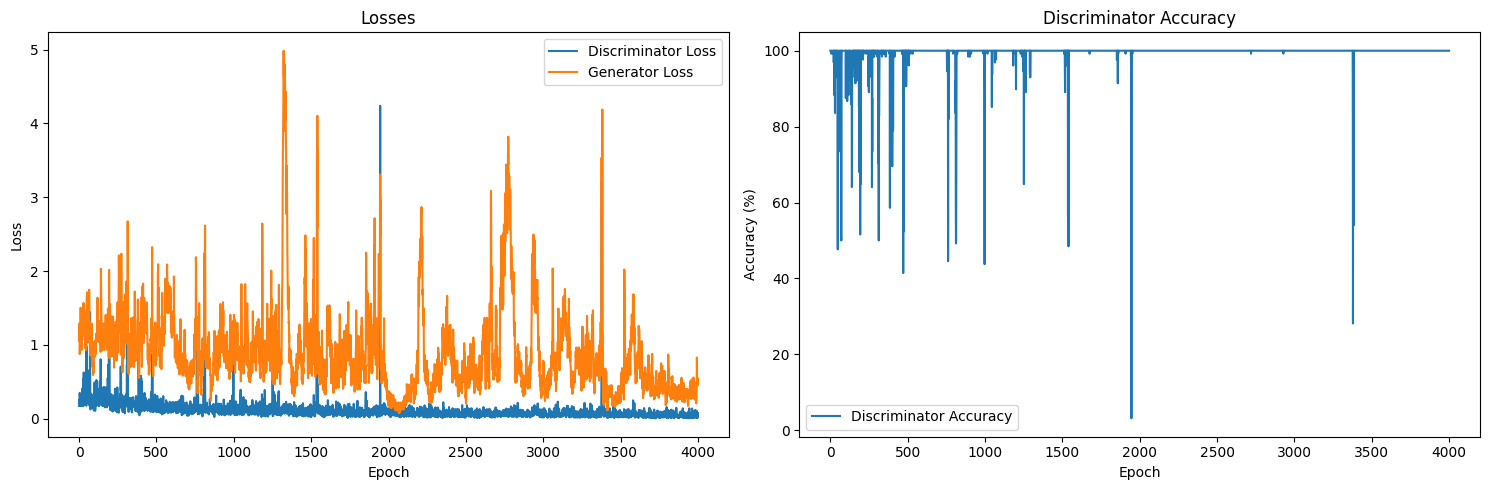

In [49]:
# Plot the results
plot_metrics(d_losses, g_losses, d_accuracies)

In [54]:
def test_generator(num_samples=10):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    sampled_labels = np.arange(0, num_samples) % num_classes

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(1, num_samples, figsize=(20, 2))
    for i in range(num_samples):
        axs[i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
        axs[i].set_title(f"Class: {sampled_labels[i]}")
        axs[i].axis('off')
    plt.show()


1/1 [==============================] - 0s 22ms/step


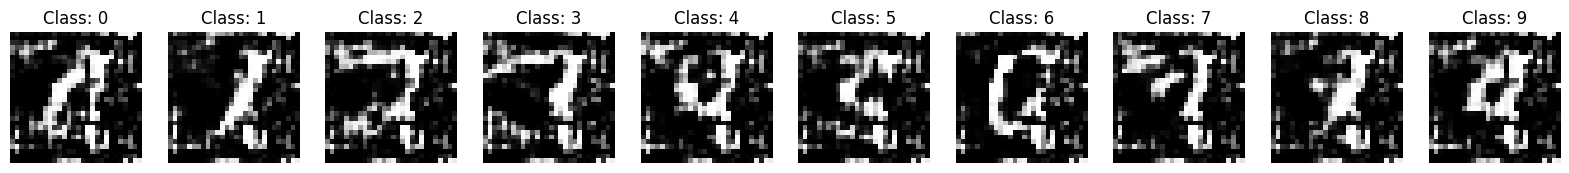

In [55]:
# Test the generator
test_generator(num_samples=10)